In [1]:
%cd ..

/home/burak/repos/smartrag


In [2]:
from disambiguation_methods.qa import chain_answer, IS_BOOL
from disambiguation_methods.score import chain_score
from disambiguation_methods.score_2 import chain_score as chain_score2

from collections import defaultdict
from disambiguation_methods.qa import AnswerStr
from disambiguation_methods.score import AnswerJudge
from langchain_core.runnables import RunnableLambda, RunnableParallel, RunnableConfig
from models import QueryAmbiguation
import pandas as pd
import json
from disambiguation_methods.domain_extractor import categories

from tqdm import tqdm

In [7]:
top_n = 10
dataset_name = "ambiguity/ai_generated"
experiment = f"ambiguous_top{top_n}+DOMAIN+Intent+Dtype+MLM+TE+LLM"
# experiment = "unfiltered+DOMAIN+Intent+Dtype"

In [8]:
df = pd.read_csv(f"./data/{dataset_name}_{experiment}.csv")

### Ambiguity Experiments

In [9]:
lm1 = RunnableLambda(lambda x: chain_answer.invoke(x["amb"]) if x["amb"] is not None else None)
lm2 = RunnableLambda(lambda x: chain_answer.invoke(x["unamb"]) if x["unamb"] is not None else None)
lm3 = RunnableLambda(lambda x: chain_answer.invoke(x["disamb"]))
chain_ = RunnableParallel(amb=lm1, unamb=lm2, disamb=lm3)

In [15]:
methods = [
    "MLM",
    "TE",
    "LLM",
    "LLM_NO_INTENT",
    "LLM_NO_DOMAIN",
    "LLM_NO_DTYPE",
    # "LLM2",
    "LLM_SUGGEST_ONLY",
]

In [16]:
llm_name = "gpt35"

In [17]:
for method_idx, method in enumerate(methods[3:], 3):
    for df_index in tqdm(range(len(df))):
        ambiguities = QueryAmbiguation(**json.loads(df.loc[df_index, "possible_ambiguities"]))
        if "LLM_SUGGEST_ONLY" not in method:
            most_likely_full_forms: list[str] = json.loads(
                df.loc[df_index, f"{method.split("_")[0]}_most_likely_full_forms"]
            )
        else:
            most_likely_full_forms: list[str] = json.loads(df.loc[df_index, f"llm_full_form_suggestions"])

        disambiguated_question_answers = []
        unambiguous_question_answers = []
        ambiguous_question_answers = []

        evaluation = {"amb": [], "disamb": [], "unamb": []}

        for amb_idx, (full_form, amb) in enumerate(zip(most_likely_full_forms, ambiguities.full_form_abbrv_map)):
            amb_question: str = df.loc[df_index, "ambiguous_question"]
            unamb_question: str = df.loc[df_index, "unambiguous_question"]

            disambiguated_question = amb_question.replace(amb.abbreviation, amb.abbreviation + f" ({full_form})")
            df.loc[df_index, "disambiguated_question"] = disambiguated_question

            answer: str = df.loc[df_index, "answer"] if "answer" in df else ""

            response: dict[str, AnswerStr] = chain_.invoke(
                {
                    "amb": (
                        {
                            "query": amb_question,
                            "intent": df.loc[df_index, "intent"] if "NO_INTENT" not in method else "'Not Specified'",
                            "domain": df.loc[df_index, "domain"] if "NO_DOMAIN" not in method else "'Not Specified'",
                            "dtype": df.loc[df_index, "dtype"] if "NO_DTYPE" not in method else "'Not Specified'",
                        }
                    )
                    if f"{methods[method_idx - 1]}_ambiguous_question_answered_by_{llm_name}_correct" not in df.columns
                    else None,
                    "unamb": (
                        {
                            "query": unamb_question,
                            "intent": df.loc[df_index, "intent"] if "NO_INTENT" not in method else "'Not Specified'",
                            "domain": df.loc[df_index, "domain"] if "NO_DTYPE" not in method else "'Not Specified'",
                            "dtype": df.loc[df_index, "dtype"] if "NO_DTYPE" not in method else "'Not Specified'",
                        }
                    )
                    if f"{methods[method_idx - 1]}_unambiguous_question_answered_by_{llm_name}_correct"
                    not in df.columns
                    else None,
                    "disamb": {
                        "query": disambiguated_question,
                        "intent": df.loc[df_index, "intent"] if "NO_INTENT" not in method else "'Not Specified'",
                        "domain": df.loc[df_index, "domain"] if "NO_DTYPE" not in method else "'Not Specified'",
                        "dtype": df.loc[df_index, "dtype"] if "NO_DTYPE" not in method else "'Not Specified'",
                    },
                },
                RunnableConfig(configurable={"llm": "gpt35"}),
            )

            response_: AnswerJudge = chain_score.invoke(
                {
                    "answer": answer
                    if answer
                    else (
                        (response["unamb"].answer)
                        if f"{methods[method_idx - 1]}_unambiguous_question_answered_by_{llm_name}" not in df.columns
                        else json.loads(
                            df.loc[df_index, f"{methods[method_idx - 1]}_unambiguous_question_answered_by_{llm_name}"]
                        )[amb_idx]
                    ),
                    "amb": (
                        (response["amb"].answer)
                        if f"{methods[method_idx - 1]}_ambiguous_question_answered_by_{llm_name}" not in df.columns
                        else json.loads(
                            df.loc[df_index, f"{methods[method_idx - 1]}_ambiguous_question_answered_by_{llm_name}"]
                        )[amb_idx]
                    ),
                    "unamb": (
                        (response["unamb"].answer)
                        if f"{methods[method_idx - 1]}_unambiguous_question_answered_by_{llm_name}" not in df.columns
                        else json.loads(
                            df.loc[df_index, f"{methods[method_idx - 1]}_unambiguous_question_answered_by_{llm_name}"]
                        )[amb_idx]
                    ),
                    "disamb": response["disamb"].answer,
                    "query": unamb_question,
                }
            )

            # amb, unamb, disamb

            disambiguated_question_answers.append(response["disamb"].answer)
            unambiguous_question_answers.append(
                (response["unamb"].answer)
                if f"{methods[method_idx - 1]}_unambiguous_question_answered_by_{llm_name}" not in df.columns
                else json.loads(
                    df.loc[df_index, f"{methods[method_idx - 1]}_unambiguous_question_answered_by_{llm_name}"]
                )[amb_idx]
            )
            ambiguous_question_answers.append(
                (response["amb"].answer)
                if f"{methods[method_idx - 1]}_ambiguous_question_answered_by_{llm_name}" not in df.columns
                else json.loads(
                    df.loc[df_index, f"{methods[method_idx - 1]}_ambiguous_question_answered_by_{llm_name}"]
                )[amb_idx]
            )

            evaluation["amb"].append(response_.bit1 == 1)
            evaluation["unamb"].append(response_.bit2 == 1)
            evaluation["disamb"].append(response_.bit3 == 1)

        df.loc[df_index, f"{method}_disambiguated_question_answered_by_{llm_name}_correct"] = json.dumps(
            evaluation["disamb"]
        )
        df.loc[df_index, f"{method}_unambiguous_question_answered_by_{llm_name}_correct"] = json.dumps(
            evaluation["unamb"]
        )
        df.loc[df_index, f"{method}_ambiguous_question_answered_by_{llm_name}_correct"] = json.dumps(evaluation["amb"])

        df.loc[df_index, f"{method}_disambiguated_question_answered_by_{llm_name}"] = json.dumps(
            disambiguated_question_answers
        )
        df.loc[df_index, f"{method}_unambiguous_question_answered_by_{llm_name}"] = json.dumps(
            unambiguous_question_answers
        )
        df.loc[df_index, f"{method}_ambiguous_question_answered_by_{llm_name}"] = json.dumps(ambiguous_question_answers)

  0%|          | 0/150 [00:00<?, ?it/s]

100%|██████████| 150/150 [08:46<00:00,  3.51s/it]


In [19]:
df.to_csv(f"./data/{dataset_name}_{experiment}_top{top_n}+DOMAIN+Intent+Dtype+MLM+TE+LLM+eval.csv", index=False)

In [20]:
import numpy as np

eval_df = pd.DataFrame(
    columns=["dataset_name", "method", "ambiguous_accuracy", "unambiguous_accuracy", "disambiguated_accuracy"]
)
from glob import glob

for file in glob("./data/ambiguity/*eval.csv"):
    dataset_name = file.split("_")[0].split("/")[-1]
    df = pd.read_csv(file)
    for method in methods:
        if any(map(lambda x: method in x, df.columns)):
            eval_df = pd.concat(
                [
                    eval_df,
                    pd.DataFrame(
                        [
                            {
                                "dataset_name": dataset_name,
                                "method": method,
                                "ambiguous_accuracy": df[f"{method}_ambiguous_question_answered_by_gpt35_correct"]
                                .apply(lambda x: np.mean(json.loads(x)))
                                .mean(),
                                "unambiguous_accuracy": df[f"{method}_unambiguous_question_answered_by_gpt35_correct"]
                                .apply(lambda x: np.mean(json.loads(x)))
                                .mean(),
                                "disambiguated_accuracy": df[
                                    f"{method}_disambiguated_question_answered_by_gpt35_correct"
                                ]
                                .apply(lambda x: np.mean(json.loads(x)))
                                .mean(),
                            }
                        ]
                    ),
                ],
                ignore_index=True,
            )
eval_df

/tmp/ipykernel_45870/3646411442.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  eval_df = pd.concat(


,dataset_name,method,ambiguous_accuracy,unambiguous_accuracy,disambiguated_accuracy
0,ai,MLM,0.860000,0.966667,0.673333
1,ai,TE,0.853333,0.966667,0.780000
2,ai,LLM,0.860000,0.953333,0.853333
3,ai,LLM_NO_INTENT,0.860000,0.953333,0.833333
4,ai,LLM_NO_DOMAIN,0.853333,0.953333,0.840000
5,ai,LLM_NO_DTYPE,0.853333,0.940000,0.860000
6,ai,LLM_SUGGEST_ONLY,0.860000,0.960000,0.853333
7,medquad,MLM,0.591346,0.860577,0.490385
8,medquad,TE,0.586538,0.865385,0.600962
9,medquad,LLM,0.579327,0.872596,0.687500


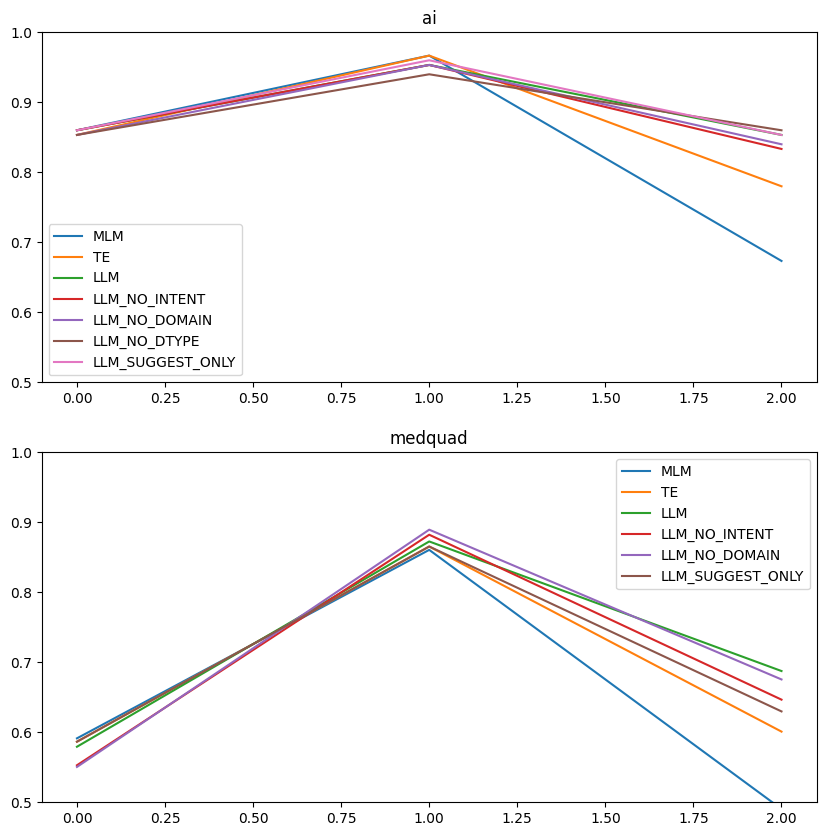

In [29]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(eval_df["dataset_name"].nunique(), 1, figsize=(10, 10))

for axs, (_, group_df) in zip(axes, eval_df.groupby(by="dataset_name")):
    for i, (_, row) in enumerate(group_df.iterrows()):
        axs.plot(
            range(3),
            [row["ambiguous_accuracy"], row["unambiguous_accuracy"], row["disambiguated_accuracy"]],
            label=row["method"],
        )
        axs.set_title(row["dataset_name"])
        axs.set_ylim(0.5, 1)
        axs.legend()
plt.show()

### Intent+Domain+Dtype Experiments

In [14]:
lm1 = RunnableLambda(lambda x: chain_answer.invoke(x["raw"]) if x["raw"] is not None else None)
lm2 = RunnableLambda(lambda x: chain_answer.invoke(x["analyzed"]))
chain_ = RunnableParallel(raw=lm1, analyzed=lm2)

In [30]:
methods = [
    "RAW_NO_DTYPE",
    "RAW_ALL",
    "RAW_NO_DOMAIN",
    "RAW_NO_INTENT",
]

In [18]:
from disambiguation_methods.qa import AnswerBool

llm_name = "gpt35"

for method_idx, method in enumerate(methods):
    for df_index in tqdm(range(len(df))):
        question: str = df.loc[df_index, "question"]
        answer: str | bool = df.loc[df_index, "answer"] if "answer" in df else ""

        response: dict[str, AnswerStr | AnswerBool] = chain_.invoke(
            {
                "analyzed": {
                    "query": question,
                    "intent": df.loc[df_index, "intent"] if "NO_INTENT" not in method else "'Not Specified'",
                    "domain": df.loc[df_index, "domain"] if "NO_DOMAIN" not in method else "'Not Specified'",
                    "dtype": df.loc[df_index, "dtype"] if "NO_DTYPE" not in method else "'Not Specified'",
                },
                "raw": (
                    {
                        "query": question,
                        "intent": "'Not Specified'",
                        "domain": "'Not Specified'",
                        "dtype": "'Not specified'",
                    }
                )
                if f"{methods[method_idx - 1]}_raw_question_answered_by_{llm_name}" not in df.columns
                else None,
            },
            RunnableConfig(configurable={"llm": llm_name}),
        )
        if not IS_BOOL:
            response_: AnswerJudge = chain_score2.invoke(
                {
                    "answer": answer
                    if answer
                    else (
                        (response["raw"].answer)
                        if f"{methods[method_idx - 1]}_raw_question_answered_by_{llm_name}" not in df.columns
                        else df.loc[df_index, f"{methods[method_idx - 1]}_raw_question_answered_by_{llm_name}"]
                    ),
                    "raw": (
                        (response["raw"].answer)
                        if f"{methods[method_idx - 1]}_raw_question_answered_by_{llm_name}" not in df.columns
                        else df.loc[df_index, f"{methods[method_idx - 1]}_raw_question_answered_by_{llm_name}"]
                    ),
                    "analyzed": response["analyzed"].answer,
                    "query": question,
                }
            )

            df.loc[df_index, f"{method}_raw_question_answered_by_{llm_name}_correct"] = response_.bit1 == 1
            df.loc[df_index, f"{method}_analyzed_question_answered_by_{llm_name}_correct"] = response_.bit2 == 1
        else:
            df.loc[df_index, f"{method}_raw_question_answered_by_{llm_name}_correct"] = (
                (response["raw"].answer == answer)
                if f"{methods[method_idx - 1]}_raw_question_answered_by_{llm_name}_correct" not in df.columns
                else df.loc[df_index, f"{methods[method_idx - 1]}_raw_question_answered_by_{llm_name}_correct"]
            )
            df.loc[df_index, f"{method}_analyzed_question_answered_by_{llm_name}_correct"] = (
                response["analyzed"].answer == answer
            )

        df.loc[df_index, f"{method}_analyzed_question_answered_by_{llm_name}"] = response["analyzed"].answer
        df.loc[df_index, f"{method}_raw_question_answered_by_{llm_name}"] = (
            (response["raw"].answer)
            if f"{methods[method_idx - 1]}_raw_question_answered_by_{llm_name}" not in df.columns
            else df.loc[df_index, f"{methods[method_idx - 1]}_raw_question_answered_by_{llm_name}"]
        )

100%|██████████| 150/150 [01:24<00:00,  1.77it/s]


In [18]:
# df = df.rename(
#     columns={
#         col: col.replace("raw", "analyzed")
#         if "raw" in col
#         else (col.replace("analyzed", "raw") if "analyzed" in col else col)
#         for col in df.columns
#     }
# )

./data/unfiltered/medquad_unfiltered+DOMAIN+Intent+Dtype+eval.csv
./data/unfiltered/boolq_unfiltered+DOMAIN+Intent+Dtype+eval.csv
./data/unfiltered/finqabench_unfiltered+DOMAIN+Intent+Dtype+eval.csv
./data/unfiltered/strategyqa_unfiltered+DOMAIN+Intent+Dtype+eval.csv


In [31]:
eval_df = pd.DataFrame(columns=["dataset_name", "method", "raw_accuracy", "analyzed_accuracy"])
from glob import glob

for file in glob("./data/unfiltered/*eval.csv"):
    dataset_name = file.split("_")[0].split("/")[-1]
    df = pd.read_csv(file)
    for method in methods:
        eval_df = pd.concat(
            [
                eval_df,
                pd.DataFrame(
                    [
                        {
                            "dataset_name": dataset_name,
                            "method": method,
                            "raw_accuracy": (df[f"{method}_raw_question_answered_by_{llm_name}_correct"] * 1.0).mean(),
                            "analyzed_accuracy": (
                                df[f"{method}_analyzed_question_answered_by_{llm_name}_correct"] * 1.0
                            ).mean(),
                        }
                    ]
                ),
            ],
            ignore_index=True,
        )
eval_df

/tmp/ipykernel_45870/3206462580.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  eval_df = pd.concat(


,dataset_name,method,raw_accuracy,analyzed_accuracy
0,medquad,RAW_NO_DTYPE,0.880000,0.880000
1,medquad,RAW_ALL,0.853333,0.833333
2,medquad,RAW_NO_DOMAIN,0.873333,0.826667
3,medquad,RAW_NO_INTENT,0.860000,0.860000
4,boolq,RAW_NO_DTYPE,0.746667,0.733333
5,boolq,RAW_ALL,0.746667,0.726667
6,boolq,RAW_NO_DOMAIN,0.746667,0.720000
7,boolq,RAW_NO_INTENT,0.746667,0.740000
8,finqabench,RAW_NO_DTYPE,0.420000,0.490000
9,finqabench,RAW_ALL,0.470000,0.440000


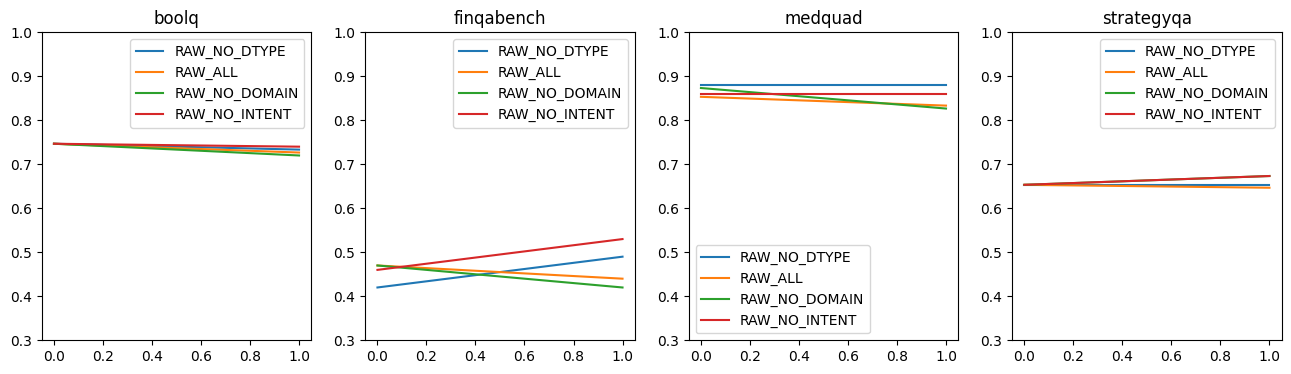

In [34]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, eval_df["dataset_name"].nunique(), figsize=(eval_df["dataset_name"].nunique() * 4, 4))

for ax, (i, group_df) in zip(axes, eval_df.groupby(by=["dataset_name"])):
    for _, row in group_df.iterrows():
        ax.plot(
            range(2),
            [row["raw_accuracy"], row["analyzed_accuracy"]],
            label=row["method"],
        )
        ax.set_ylim(0.3, 1)
        ax.set_title(row["dataset_name"])
        ax.legend()
plt.show()

In [20]:
df.to_csv(f"./data/{dataset_name}_{experiment}+eval.csv", index=False)